# Estimating errors between two trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import validator as validator
from utils import *
from matplotlib.ticker import MaxNLocator

In [2]:
dist, dist_to_line = distance, distance_to_line

def find_next_focus_point1(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to the two current points (p1 or q1)
    Returns: True if p2 is the next focus point, False if q2
    """
    return min(dist(p2, p1), dist(p2, q1)) < min(dist(q2, p1), dist(q2, q1)) #p2 is the closest point

def find_next_focus_point2(p1, p2, q1, q2):
    """
    The closest point (p2 or q2) to its respective point (p1 or q1)
    """
    return dist(p2, p1) < dist(q2, q1) #p2 is the closest point
    
def find_next_focus_point3(p1, p2, q1, q2):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)


def find_next_focus_point4(p1, p2, q1, q2, oldpoint):
    """
    distance between p2 (or q1) and the line (p1q1) 
    """
    wrong_side = orientation(p1, q1, oldpoint)
    if orientation(p1, q1, p2) == wrong_side:
        return False
    elif orientation(p1, q1, q2) == wrong_side:
        return True
    else:
        return dist_to_line(*(p1, q1), p2) < dist_to_line(*(p1, q1), q2)

In [3]:
def sort_points_over_seg(A, B, points):
    return sorted(points, key = lambda p : distance(p, A))

In [4]:
def add_intersections(A, B):
    S = []
    for i in range(len(A)-1):
        line = []
        S.append(A[i])
        for j in range(i, len(B)-1):
            intersect = intersection_btw_segs(A[i], A[i+1], B[j], B[j+1])
            if np.all(intersect != np.inf):
                line.append(intersect)
        S.extend(sort_points_over_seg(A[i], A[i+1], line))
    return np.array(S)

[[ 0.          1.        ]
 [ 0.5         2.        ]
 [ 0.625       2.25      ]
 [ 1.          3.        ]
 [ 1.33333333  2.66666667]
 [ 2.          2.        ]
 [ 2.22222222  1.33333333]
 [ 3.         -1.        ]
 [ 4.          2.        ]]


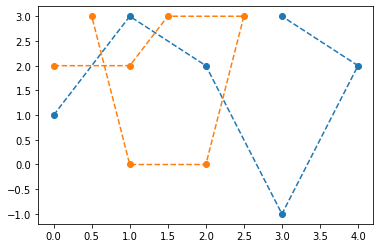

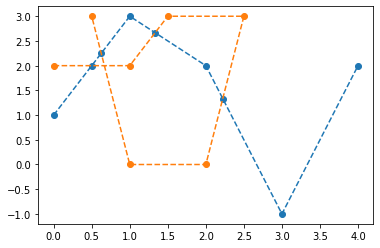

In [119]:
X = np.array([[0, 1], [1, 3], [2, 2], [3, -1], [4, 2], [3, 3]])
Y = np.array([[0, 2], [1, 2], [1.5, 3], [2.5, 3], [2, 0], [1, 0], [0.5, 3]])
plt.plot(*X.T, '--o')
plt.plot(*Y.T, '--o')
S = add_intersections(X, Y)
plt.figure()
print(S)
plt.plot(*S.T, '--o')
plt.plot(*T.T, '--o')

In [ ]:
def error_btw_trajectories(S, T):
    S = add_intersections(S, T)
    dir_point = (S[0] * T[0] / 2)
    

### *Idea 2* -  separation of cases when changing orientation

In [3]:
def error_btw_trajectories(S, T):
    i, j = 0, 0 # i (or j) is the index of the current point along S (or T)
    si, tj = S[i], T[j]
    plt.figure()
    plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid()
    error, old_point, dir_point = 0, si, (si + tj) / 2
    plt.axis("equal")
    while i < len(S) - 1 and j < len(T) - 1:
#         plt.show()
#         plt.figure()
#         plt.plot(*S.transpose(), '-o', *T.transpose(), '-o')
#         ax = plt.gca()
#         ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#         ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.grid()
#         print(i, j, si, S[i+1], tj, T[j+1])
        # 1. Check whether or not there is an intersection between the two next segments
        intersect = intersection_btw_segs(si, S[i+1], tj, T[j+1])
        if np.all(intersect != np.inf): # if the segments [S_i, S_i+1] and [T_i, T_i+1] intersect
#             print(">> Intersection")
            # Compute area of the triangle intersect, si, tj
            error += triangle_area(si, tj, intersect, ax)
            plt.plot(*intersect, 'og')
            if find_next_focus_point1(si, S[i+1], tj, T[j+1]):
                old_point = si
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                si, i = S[i+1], i+1
                tj = intersect
            else:
                old_point = tj
                dir_point = (si + tj)/2 # TODO : is this a good idea ??????????
                tj, j = T[j+1], j+1
                si = intersect
        # If there is no intersection, we have to check the orientation of the two next points
        else:
            orientation_s, orientation_t = orientation(si, tj, S[i+1]), orientation(si, tj, T[j+1])
#             print("orientation", orientation_s, orientation_t)
            if orientation_s == 0 and orientation_t == 0:
#                 print("Strange ...")
                if find_next_focus_point2(si, S[i+1], tj, T[j+1]):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            elif orientation_s == orientation_t or orientation_s == 0 or orientation_t==0:
#                 print("old point", old_point, "dir_point", dir_point)
                #simple case : S[i+1] and T[j+1] are on the side of the line (si, tj)
                if orientation_s == 0 or find_next_focus_point4(si, S[i+1], tj, T[j+1], old_point):
                    old_point, dir_point = si, si
                    si, i = S[i+1], i+1
                else:
                    old_point, dir_point = tj, tj
                    tj, j = T[j+1], j+1
            else : #one point is on the "wrong" side of the line 
#                 print(">> chgt d'angle")
                wrong_side = orientation(si, tj, dir_point) # TODO consider the case when oldpoint==si==tj
                if wrong_side == 0:
                    print("TODO ...")
                    input()
                elif orientation_s == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of T
                    intersect = intersection_btw_line_seg(si, S[i+1], tj, T[j+1])
                    if np.all(intersect == np.inf):
                        old_point = tj
                        tj, j = T[j+1], j+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo A")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                        input()
                    else:
                        old_point, tj = tj, intersect
#                         tj = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        si, i = S[i+1], i+1 #TODO deplacer directement le pivot si
                        old_point = si
                elif orientation_t == wrong_side: # we have to find the intersection between the line (si,S[i+1]) and a segment of S
                    intersect = intersection_btw_line_seg(tj, T[j+1], si, S[i+1])
                    if np.all(intersect == np.inf):
                        old_point = si
                        si, i = S[i+1], i+1
                    elif np.all(intersect == - np.inf):
                        print("Erreur dans l'algo B")
                        print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side, old_point)
                        input()
                    else:
                        old_point, si = si, intersect
#                         si = intersect
                        error += triangle_area(old_point, si, tj, ax)
                        tj, j = T[j+1], j+1
                        old_point = tj
                else:
                    print("There is a problem ?")
                    print(i, j, si, tj, S[i+1], T[j+1], orientation_s, orientation_t, wrong_side)
                    input()

            # Compute area of the triangle old_point, si, tj
            error += triangle_area(old_point, si, tj, ax)
#         plt.plot(*si, 'rx')
#         plt.plot(*tj, 'rx')
#         plt.plot(*old_point, 'kx')
#         plt.plot(*dir_point, 'cx')
    
    if i == len(S) - 1:
        error += triangle_area(si, tj, T[j+1], ax)
        j += 1
        for j in range(j, len(T)-1):
            error += triangle_area(si, T[j], T[j+1], ax)
    elif j == len(T) - 1: #else ?
        error += triangle_area(tj, si, S[i+1], ax)
        i += 1
        for i in range(i, len(S)-1):
            error += triangle_area(tj, S[i], S[i+1], ax)
    plt.show()
    Slen = sum(norm(S[i+1] - S[i]) for i in range(len(S) - 1))
    return error / Slen

test13.txt	TODO ...


KeyboardInterrupt: 

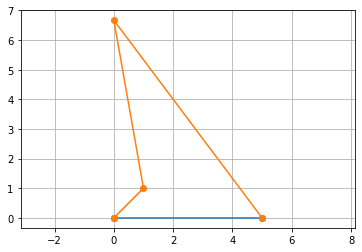

In [4]:
validator.test(error_btw_trajectories, samples_range = slice(5, None), dirname = "test/")

### Unittesting

In [4]:
import unittest
from os import listdir

In [5]:
def fetch_test_data(dirname, correct = True, criterion = '.txt', sep = ',', samples = slice(0, None)):
    """
    >>> fetch_test_data("../indoor-location-oracles/Oracles/CorrectInputTrajectories/")[0]
    ['10_parallelTrajectories.txt', array([[1., 1.],
           [3., 1.]]), array([[1., 2.],
           [3., 2.]]), 1.0, 0.001]
    >>> fetch_test_data("../indoor-location-oracles/Oracles/IncorrectInputTrajectories/", False)[2]
    [array([[0., 0.],
           [1., 0.]]), array([], dtype=float64)]
    >>> fetch_test_data("../indoor-location-oracles/Oracles/IncorrectInputTrajectories/", False)[1]
    [array([[0., 1.]]), array([], dtype=float64)]
    """
    test_file_names = [filename for filename in listdir(dirname) if criterion in filename]
    tests_sample = []
    for filename in sorted(test_file_names)[samples]:
        with open(dirname + filename, "r") as file:
            lines = file.read().splitlines() # getting rid of \n
            data = [[float(n) for n in line.split(sep) if n] for line in lines] # parse data
        
        reference = np.array(list(zip(data[0], data[1]))) # line 0 : x-axis of the reference trajectory, line 1 : y-axis
        acquired = np.array(list(zip(data[2], data[3])))  # line 2 : x-axis of the acquired trajectory, line 3 : y-axis
        if correct:
            expected_output, = data[4] or [-1]
            epsilon, = data[5] or [-1]
            tests_sample.append([filename, reference, acquired, expected_output, epsilon])
        else:
            tests_sample.append([reference, acquired])
    return tests_sample

if __name__ == "__main__":
    doctest.testmod()

In [6]:
class TestEstimator(unittest.TestCase):
    
    def test_incorrect_input(self):
        dirname = "../indoor-location-oracles/Oracles/IncorrectInputTrajectories/"
        for reference, acquired in fetch_test_data(dirname, correct = False):
            with self.assertRaises(AssertionError):
                error_btw_trajectories(reference, acquired)
    
    def test_correct_input(self):
        dirname = "../indoor-location-oracles/Oracles/CorrectInputTrajectories/"
        for filename, reference, acquired, expected_output, epsilon \
         in fetch_test_data(dirname, samples = slice(0,None)):
            output = error_btw_trajectories(reference, acquired)

            with self.subTest(test = filename, output = output, expected_output = expected_output):
                self.assertLessEqual(abs(expected_output - output), epsilon)

In [ ]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestEstimator)
unittest.TextTestRunner().run(suite)